In [1]:
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = ''

import numpy as np
import os
import cv2 as cv
import matplotlib.pyplot as plt
import glob as gb
from tqdm import tqdm
import pandas as pd
from skimage.io import imread
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Conv2D , MaxPooling2D ,concatenate ,Input ,Dropout ,UpSampling2D
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint ,TensorBoard
import tensorflow as tf
from tensorflow.python.client import device_lib

keras.backend.clear_session()

print(device_lib.list_local_devices())

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))



[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9925098987287373391
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2291924992
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1815235141838370204
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
]
2.6.0
Num GPUs Available:  1


In [2]:
def unet(input_size = (256,256,3)):
    inputs = tf.keras.layers.Input(input_size)
    s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

    #Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = tf.keras.layers.Dropout(0.2)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.2)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.3)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.3)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.4)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path 
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.3)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.3)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.2)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.2)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

In [2]:
train_img_dir='/home/vkorneychuk/projects/lum/photo/03.11/white/def_dataset/train/images/'
train_mask_dir='/home/vkorneychuk/projects/lum/photo/03.11/white/def_dataset/train/masks/'
X_train=[]
y_train=[]

files = os.listdir(train_img_dir)
for file in files:
    img=cv.imread(train_img_dir+file, cv.IMREAD_COLOR)
    X_train.append(img)

files = os.listdir(train_mask_dir)
for file in files:
    img=cv.imread(train_mask_dir+file, cv.IMREAD_GRAYSCALE)
    y_train.append(img)

X_train=np.array(X_train)
y_train=np.array(y_train,dtype=np.bool)

In [3]:
test_img_dir='/home/vkorneychuk/projects/lum/photo/03.11/white/def_dataset/test/images/'
test_mask_dir='/home/vkorneychuk/projects/lum/photo/03.11/white/def_dataset/test/masks/'
X_test=[]
y_test=[]

files = os.listdir(test_img_dir)
for file in files:
    img=cv.imread(test_img_dir+file, cv.IMREAD_COLOR)
    img=cv.cvtColor(img,cv.COLOR_BGR2RGB)
    X_test.append(img)

files = os.listdir(test_mask_dir)
for file in files:
    img=cv.imread(test_mask_dir+file, cv.IMREAD_GRAYSCALE)
    y_test.append(img)

X_test=np.array(X_test)
y_test=np.array(y_test,dtype=np.bool)

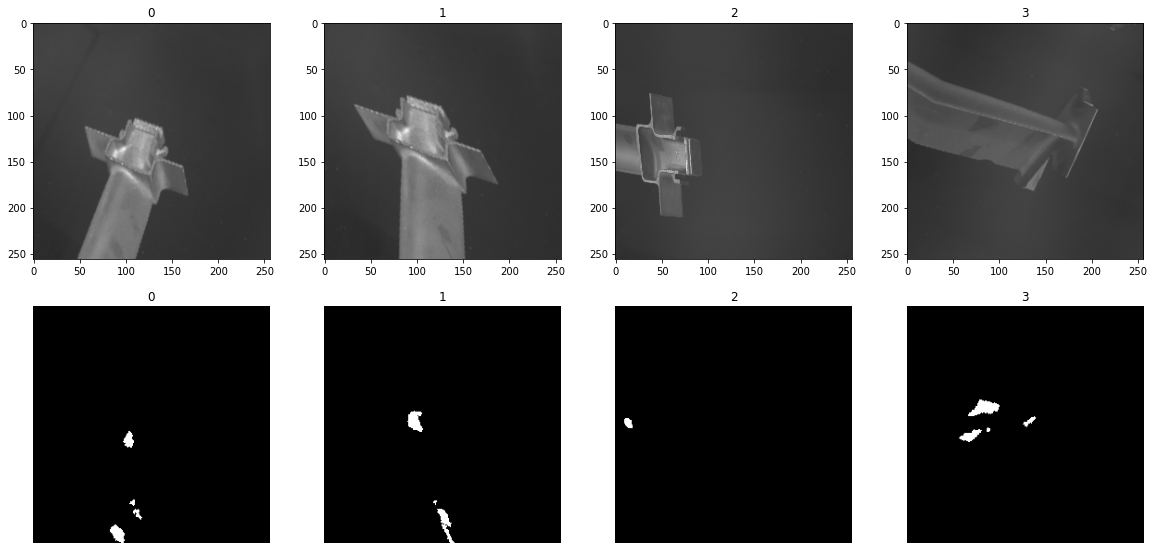

In [4]:
plt.figure(figsize=(20,20))
for n , i in enumerate(range(0,4)):
    plt.subplot(4,4,n+1)
    plt.imshow(X_train[i])
    plt.title(i)
    plt.subplot(4,4,5+n)
    plt.imshow(y_train[i],cmap='gray')
    plt.title(i)
    plt.axis('off')

In [6]:
X_train,X_valid,y_train,y_valid=train_test_split(X_train,y_train,test_size=0.2)

In [7]:
model=unet(input_size=(256,256,3))

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [9]:
optimizer_adam=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.99)

EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_accuracy',verbose=2,factor=0.5,min_lr=0.00001)
model_check=ModelCheckpoint('model.hdf5',monitor='val_loss',verbose=1,save_best_only=True)
tensorbord=TensorBoard(log_dir='logs')
callback=[EarlyStop , Reduce_LR,model_check,tensorbord]

model.compile(optimizer=optimizer_adam,loss='binary_crossentropy',metrics=['accuracy'])

In [10]:
history=model.fit(X_train,y_train,validation_data=(X_valid,y_valid),epochs=40,batch_size=16,
                  callbacks=callback, verbose=1)

Epoch 1/40
45/45 [==============================] - 18s 261ms/step - loss: 0.2364 - accuracy: 0.8565 - val_loss: 0.1538 - val_accuracy: 0.9920

Epoch 00001: val_loss improved from inf to 0.15384, saving model to model.hdf5
Epoch 2/40
45/45 [==============================] - 10s 224ms/step - loss: 0.0520 - accuracy: 0.9916 - val_loss: 0.0405 - val_accuracy: 0.9920

Epoch 00002: val_loss improved from 0.15384 to 0.04053, saving model to model.hdf5
Epoch 3/40
45/45 [==============================] - 10s 225ms/step - loss: 0.0379 - accuracy: 0.9916 - val_loss: 0.0358 - val_accuracy: 0.9920

Epoch 00003: val_loss improved from 0.04053 to 0.03579, saving model to model.hdf5
Epoch 4/40
45/45 [==============================] - 10s 226ms/step - loss: 0.0361 - accuracy: 0.9916 - val_loss: 0.0360 - val_accuracy: 0.9920

Epoch 00004: val_loss did not improve from 0.03579
Epoch 5/40
45/45 [==============================] - 10s 227ms/step - loss: 0.0347 - accuracy: 0.9916 - val_loss: 0.0373 - val_ac

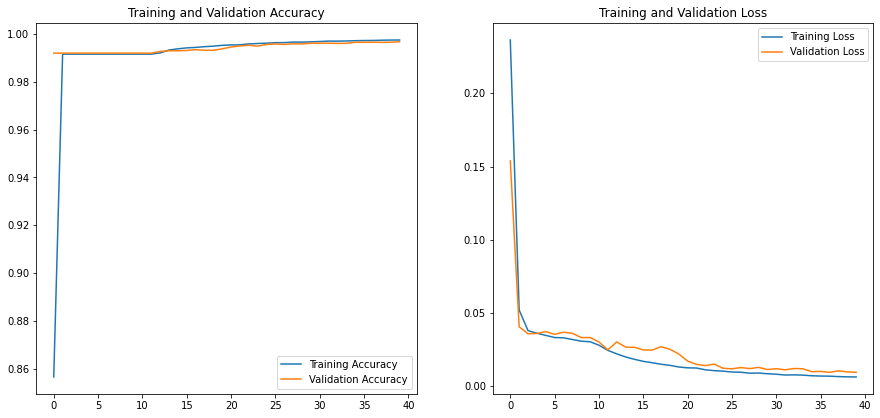

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(40)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [5]:
model = keras.models.load_model('model.hdf5')

In [6]:
y_pred=model.predict(X_test)
print(y_pred.shape)

(7, 256, 256, 1)


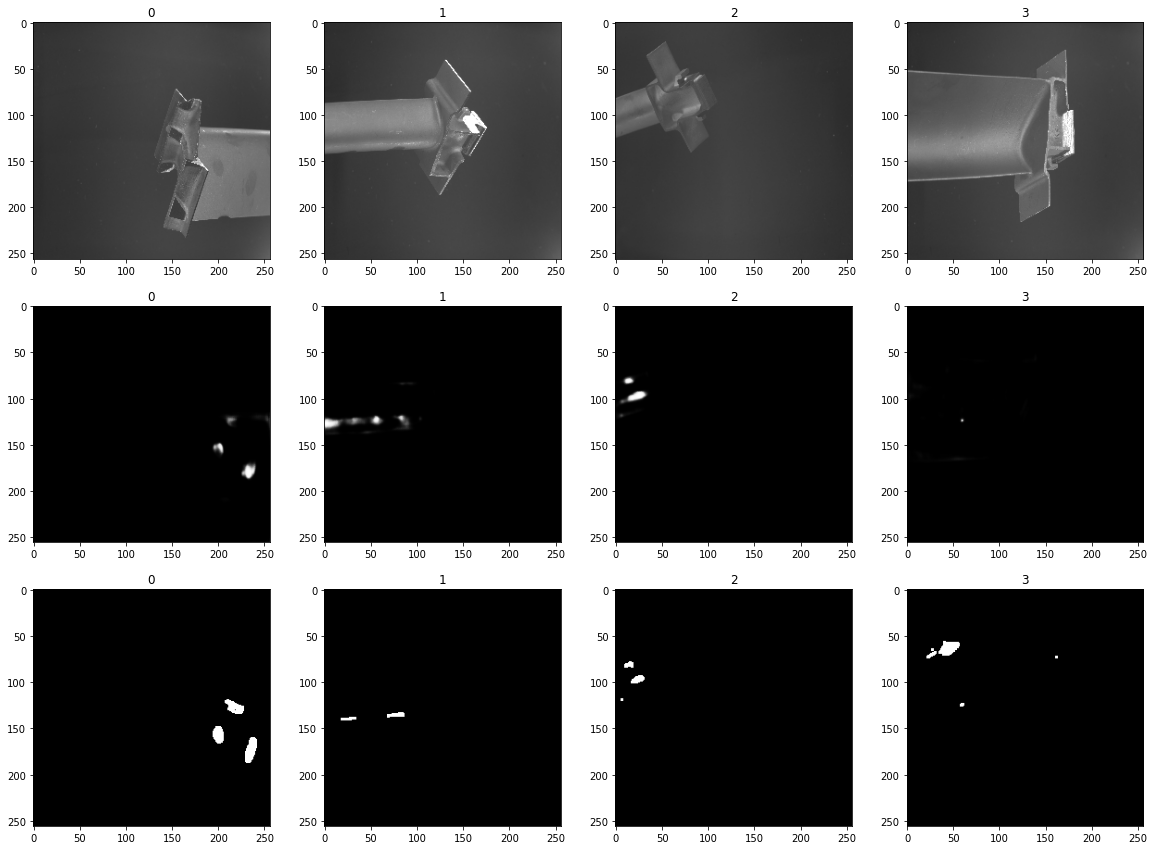

In [8]:
plt.figure(figsize=(20,20))
for n , i in enumerate(range(0,4)):
    plt.subplot(4,4,n+1)
    plt.imshow(X_test[i])
    plt.title(i)
    plt.subplot(4,4,5+n)
    plt.imshow(y_pred[i],cmap='gray')
    plt.title(i)
    plt.subplot(4,4,9+n)
    plt.imshow(y_test[i],cmap='gray')
    plt.title(i)